<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD

Using TensorFlow backend.


Model 22

In [4]:
saved_model = load_model('/content/drive/My Drive/xai_model/model_22.h5')














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
saved_model.layers[0].input_shape

(None, None, None, 3)

In [0]:
#saved_model.summary()

[[4.2885816e-08 1.1847902e-08 9.9998367e-01 9.0323711e-06 1.6631745e-09
  7.2796538e-06]]
Pitted Surface


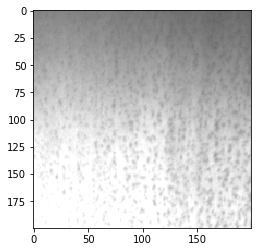

In [18]:
image_path="/content/drive/My Drive/NEU surface defect database - test split/Test/Pitted surface/PS_158.bmp"
image_path_copy = image_path
img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = saved_model.predict(img)
print(result)

prediction = result.argmax(axis=-1)

if prediction == 0:
  label = "Crazing" 
elif prediction == 1:
  label = "Inclusion"
elif prediction == 2:
  label = "Pitted Surface"
elif prediction == 3:
  label = "Patches"
elif prediction == 4:
  label = "Rolled-in scale"
elif prediction == 5:
  label = "Scratches"
else:
  label = "Exception"

print(label)

In [7]:
pip install lime

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=406a84fa9ec45a4cd62e57c14462b1aeb6b83cf04443b196dacb200214825375
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [0]:
explainer = lime_image.LimeImageExplainer()

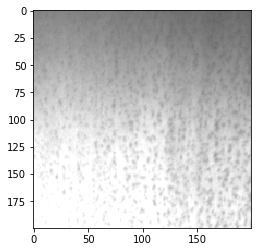

In [19]:
img = image.load_img(image_path_copy, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

In [20]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img[0], saved_model.predict, top_labels=5, hide_color=0)

CPU times: user 5.3 s, sys: 1.18 s, total: 6.48 s
Wall time: 6.29 s


In [0]:
from skimage.segmentation import mark_boundaries

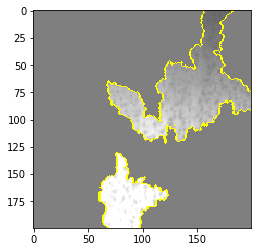

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

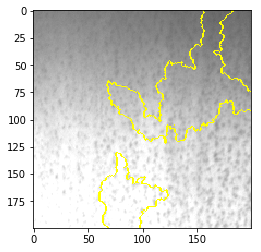

In [23]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

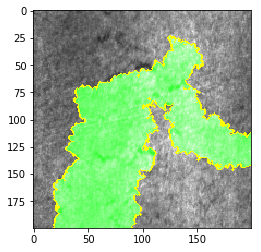

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

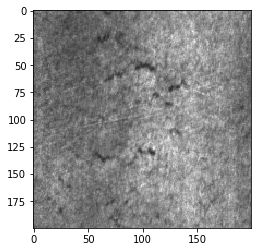

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=50, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

KeyError: ignored